In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9444444444444444, Loss: 0.25058156472665294
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.13040036625332302
Checkpoint 300, Accuracy: 0.9814814814814815, Loss: 0.10380354634037724
Checkpoint 400, Accuracy: 0.9753086419753086, Loss: 0.09476870077627676
Checkpoint 500, Accuracy: 0.9814814814814815, Loss: 0.09799140470999258


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9961676  0.00275987 0.00107251]
[1. 0. 0.] <-> [0.9836909  0.00136926 0.01493983]
[1. 0. 0.] <-> [0.9956359  0.00147563 0.00288846]
[1. 0. 0.] <-> [0.9951945 0.0013366 0.0034689]
[1. 0. 0.] <-> [0.99668014 0.00132971 0.00199013]
[1. 0. 0.] <-> [0.99714774 0.00177288 0.00107936]
[1. 0. 0.] <-> [0.9459571  0.00134256 0.05270024]
[1. 0. 0.] <-> [0.9947792  0.00131074 0.00391004]
[1. 0. 0.] <-> [0.99695086 0.00155233 0.0014967 ]
[1. 0. 0.] <-> [0.9961287  0.00134927 0.00252204]
[1. 0. 0.] <-> [0.99137723 0.00746393 0.00115871]
[1. 0. 0.] <-> [0.99585503 0.00209491 0.00205007]
[1. 0. 0.] <-> [0.99549794 0.00155101 0.00295099]
[0. 0. 1.] <-> [7.8831296e-03 1.3319201e-05 9.9210358e-01]
[1. 0. 0.] <-> [0.997509   0.00145127 0.00103968]
[1. 0. 0.] <-> [0.9858931  0.01263868 0.00146825]
[1. 0. 0.] <-> [0.995191   0.00159757 0.00321146]
[0. 1. 0.] <-> [1.0189392e-02 9.8971212e-01 9.8520875e-05]
[0. 0. 1.] <-> [6.9349329e-03 1.1735608e-05 9.9305326e-01]
[1. 0. 0.] <-> [0.99728096

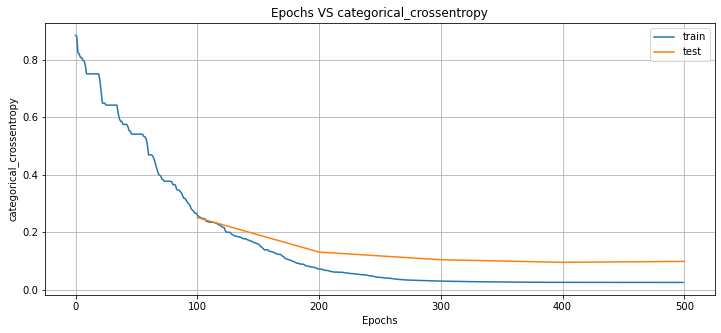

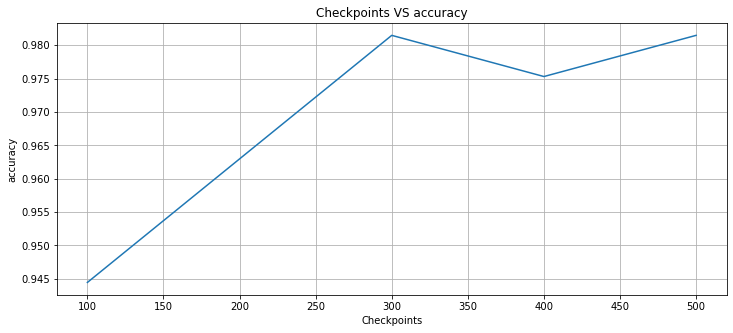

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9444444444444444, 'mean_square_error': 0.12744392807722515, 'categorical_crossentropy': 0.25058156472665294, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 8, 'tn_hit': 20, 'fn_hit': 1}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 5}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 3}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.07340673563358789, 'categorical_crossentropy': 0.13040036625332302, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 4, 'tn_hit': 24, 'fn_hit': 2}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}, 2: {'tp_hit': 11, 'fp_hit': 2, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9814814814814815, 'mean_square_error': 0.057113630248641606, 'categorical_crossentropy': 0.10380354634037724, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 2, 'tn_hit': 26, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}, 2: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 94

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-1.8997475  3.         1.7433267  0.9510747 -3.       ]
 bias: -3.0

Neuron 1: weights:
[-0.36538646  3.          3.         -3.         -3.        ]
 bias: 3.0

Neuron 2: weights:
[ 1.9297657 -3.        -2.45327   -3.         3.       ]
 bias: 3.0

Neuron 3: weights:
[ 0.0875681  -3.         -0.47452557  0.8144866   3.        ]
 bias: -3.0

$
Layer 2
Neuron 0: weights:
[-3.  3.  3. -3.]
 bias: 0.4084043800830841

Neuron 1: weights:
[ 3.         2.6922088 -3.        -3.       ]
 bias: 0.0267937071621418

Neuron 2: weights:
[-3.         -3.          0.50030047  3.        ]
 bias: 1.9186077117919922

$

